In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq

In [14]:
# Setting image settings
plt.rcParams.update({'font.size': 16})

In [15]:
# SMALL_SIZE = 10
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 20

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [152]:
class advection:
    
    def __init__(self, method):
        self.method = method

    def initial_condition(self,x,c0=10):
            if x < 1125e3 or x > 1375e3:
                return 0
            else:
                return c0

    def solve_advection_equation(self,dx=25e3,dt=1000,L=2500e3,T=160*3600,u0=10):
        '''
        Function to solve linear advection equation in x and time

        INPUT:
        Method: either Euler or Lax-Wendroff method to solve ODE
        dx = steps in x in m
        dt = timesteps in s
        L = basin length in m
        T = time duration of simulation
        u0 = initial velocity

        OUTPUT:
        C = 2D vector in [time,space]
        '''
        # Create the grid
        x = np.arange(0, L, dx)
        t = np.arange(0, T, dt)

        # Initialize the solution matrix
        C = np.zeros((len(t), len(x)))

        # Set the initial condition
        for j in range(len(x)):
            C[0,j] = self.initial_condition(x[j])

        # Compute the solution using the specified difference integration method
        if self.method == 'Euler':
            for i in range(len(t)-1):
                for j in range(1, len(x)):
                    C[i+1,j] = C[i,j] - (u0*dt/dx)*(C[i,j]-C[i,j-1])
                    # Apply periodic boundary conditions
                C[i+1,0] = C[i+1,-2]
                C[i+1,-1] = C[i+1,1]
            print(u0*dt/dx)
        elif self.method == "Lax-Wendroff":
            for i in range(len(t)-1):
                for j in range(1, len(x)-2):
                    C[i+1,j] = C[i,j]-(u0*dt/(2*dx)) * ((C[i,j+1]-C[i,j-1])) + 0.5*(np.square(u0)*np.square(dt)/np.square(dx))*(C[i,j+1]-2*C[i,j]+C[i,j-1]) 
                # Apply periodic boundary conditions
                C[i+1,0] = C[i+1,-3]
                C[i+1,-2] = C[i+1,1]
            print(u0*dt/dx)
        elif self.method == 'Spectral':

            # Compute the wavenumber
            k = fftfreq(len(x))*len(x)    
            # Define the spectral operator
            L_op = (u0/L)*2j*np.pi*k

            # Compute the solution using the Matsuno scheme
            for i in range(len(t)-1):
                # First step of Matsuno scheme
                C_hat = fft(C[i,:])
                C_tilde = C_hat  - dt*L_op*C_hat

                # Second step of Matsuno scheme
                C[i+1,:] = np.real(ifft(C_hat - dt*L_op*C_tilde)) #Using matsuno in time


                # Apply periodic boundary conditions
                C[i+1,0] = C[i+1,-2]
                C[i+1,-1] = C[i+1,1]
            print(u0*dt/dx)
        return C


In [316]:
ad1 = advection('Euler')
C_Euler = ad1.solve_advection_equation(T=100*3600)

ad2 = advection('Lax-Wendroff')
C_Lax = ad2.solve_advection_equation(T=100*3600)

ad3 = advection('Spectral')
C_spec = ad3.solve_advection_equation(dt=50,T=100*3600)


0.4
0.4
0.02


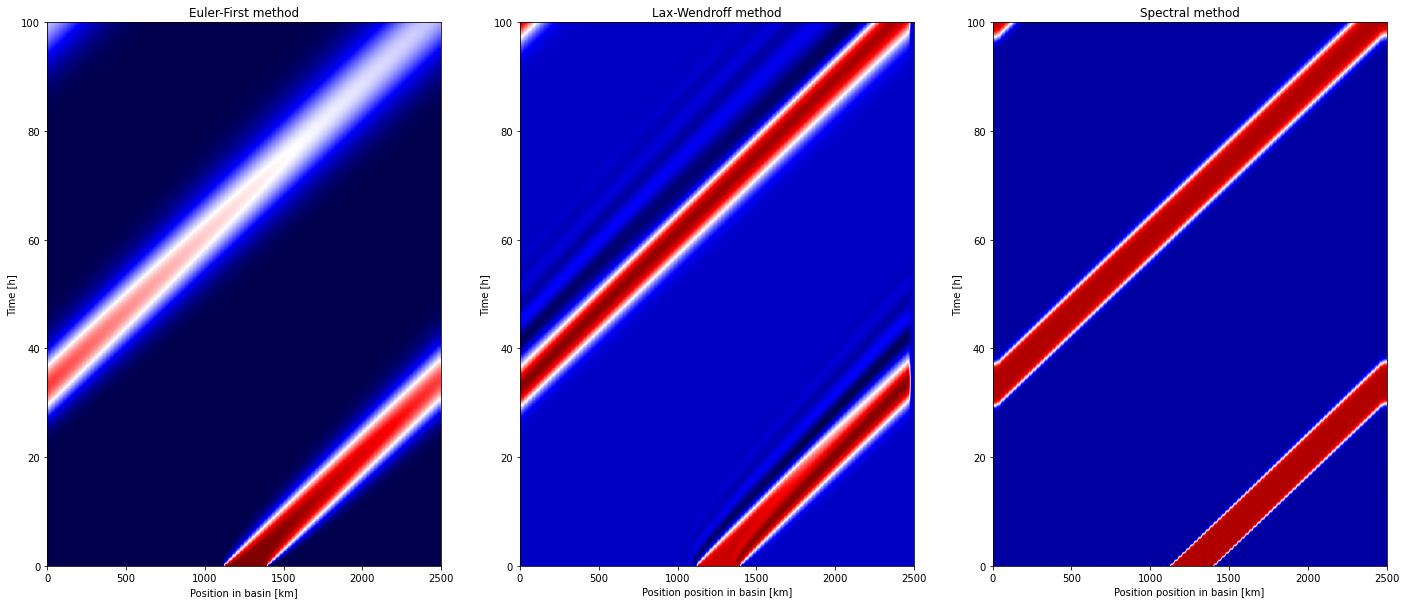

In [317]:
# Plot the solution
fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)

# First subplot
im1 = axs[0].imshow(C_Euler, aspect='auto', cmap='seismic', origin='lower', extent=[0, 2500e3/1e3, 0, 100*3600/3600])
axs[0].set_xlabel('Position in basin [km]')
axs[0].set_ylabel('Time [h]')
axs[0].set_title('Euler-First method')

# Second subplot
im2 = axs[1].imshow(C_Lax, aspect='auto', cmap='seismic', origin='lower', extent=[0, 2500e3/1e3, 0, 100*3600/3600])
axs[1].set_xlabel('Position position in basin [km]')
axs[1].set_ylabel('Time [h]')
axs[1].set_title('Lax-Wendroff method')

im2 = axs[2].imshow(C_spec, aspect='auto', cmap='seismic', origin='lower', extent=[0, 2500e3/1e3, 0, 100*3600/3600])
axs[2].set_xlabel('Position position in basin [km]')
axs[2].set_ylabel('Time [h]')
axs[2].set_title('Spectral method')



plt.show()


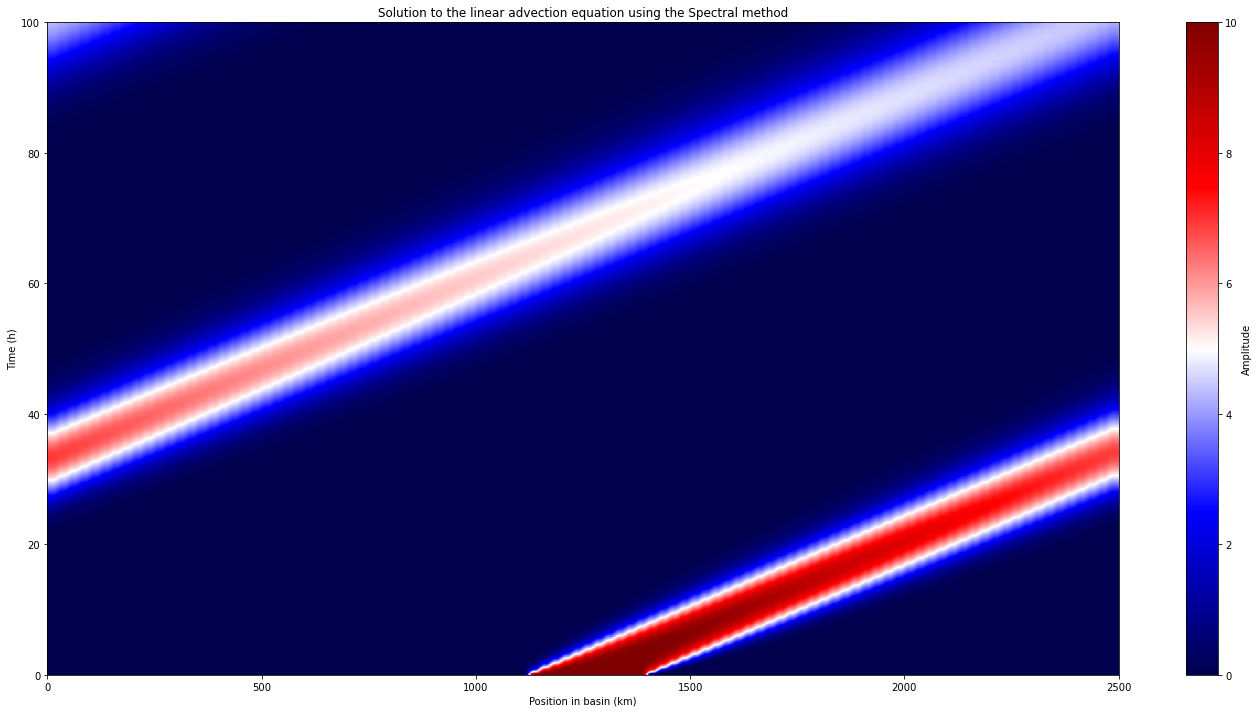

In [327]:
plt.figure(figsize=(24,12))
plt.imshow(C_Euler, aspect='auto', cmap='seismic', origin='lower', extent=[0, 2500e3/1e3, 0, 100*3600/3600]) #Change C_spec to other C for other 
plt.colorbar(label='Amplitude')
plt.xlabel('Position in basin (km)')
plt.ylabel('Time (h)')
plt.title('Solution to the linear advection equation using the Spectral method')
plt.show()

## Comparison

In [322]:
ana = []
for i in x:
    ana.append(initial_condition(i))

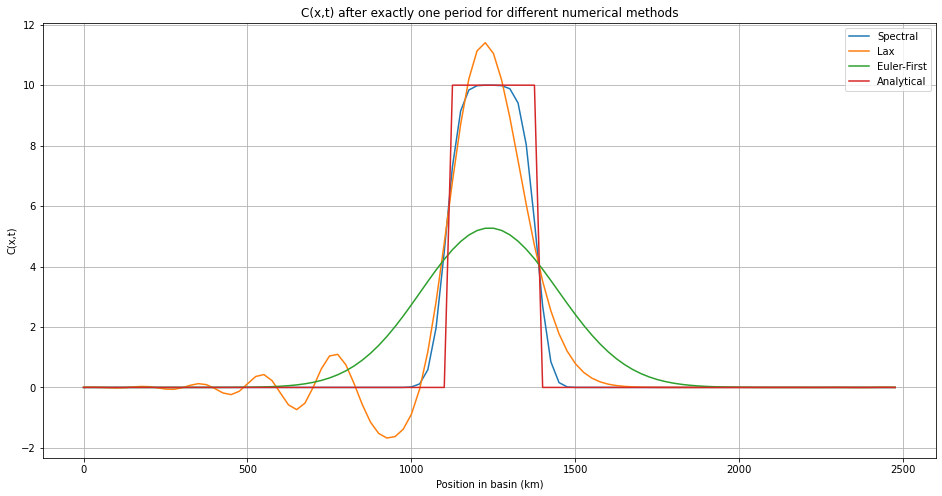

In [320]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
plt.plot(x/1e3,C_spec[4860], label='Spectral')
plt.plot(x/1e3,C_Lax[244], label='Lax')
plt.plot(x/1e3,C_Euler[244], label='Euler-First')
plt.plot(x/1e3, ana, label='Analytical')
ax.set_ylabel('C(x,t)')
ax.set_xlabel('Position in basin (km)')
ax.set_title('C(x,t) after exactly one period for different numerical methods')
ax.grid()
plt.legend()

In [324]:
np.shape(C_spec)

(7200, 100)